# Baseline simplex attention experiments

In [57]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import sys
import os
sys.path.append(os.path.abspath('../../'))  #Couldn't figure out how to get src in my path so i fixed it like this

from src.Transformer.DecoderOnly import PointSimplexDecoderOnlyTransformer
from src.Transformer.DistanceMetrics import euclidean
from src.Transformer.DistanceMetrics import cosine

import src.Datasets.SyntheticDataset as SD
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=30, delta=0)

In [58]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# meta data to store images
FOLDER = "simplex_transformer"
KERNEL_NAME = "simplex"

# transformer configs
n_layers = 2                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions
norm_first = True                       # LayerNorm order (keep consistent)

#new
distance_metric = cosine                  # Distance metric for Simplex attention
conv_out_dim = 32                            # Output dimension for convolutional part in Simplex block (example value)
kernel_size = 3                              # Kernel size for convolutional part in Simplex block (example value)


# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target using simplex attention and an euclidean distance function.

In [59]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

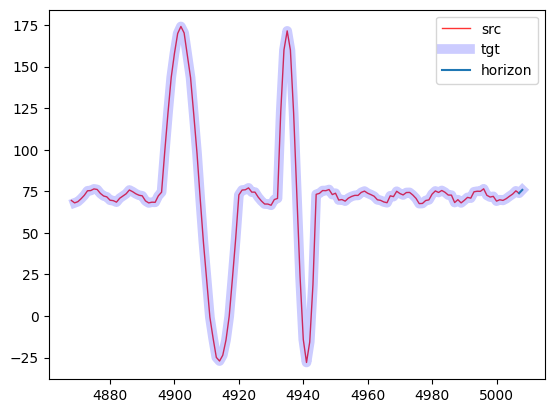

In [60]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [61]:
model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [62]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2788.6006	val_loss=1497.8635	train_mape_loss=2.4859	val_mape_loss=3.3018	R_p=['0.2745', '0.2629']
epoch=1	train_loss=1512.3050	val_loss=1491.6470	train_mape_loss=3.0627	val_mape_loss=3.2837	R_p=['0.2758', '0.2655']
epoch=2	train_loss=1494.3005	val_loss=1452.7151	train_mape_loss=3.0188	val_mape_loss=3.2887	R_p=['0.2931', '0.2591']
epoch=3	train_loss=1436.2052	val_loss=1384.3241	train_mape_loss=2.8761	val_mape_loss=3.1625	R_p=['0.3045', '0.2638']
epoch=4	train_loss=1386.1844	val_loss=1306.1357	train_mape_loss=2.7126	val_mape_loss=2.9541	R_p=['0.3089', '0.2542']
epoch=5	train_loss=1328.6969	val_loss=1129.7073	train_mape_loss=2.5086	val_mape_loss=2.1488	R_p=['0.3035', '0.2517']
epoch=6	train_loss=1272.5915	val_loss=1132.9663	train_mape_loss=2.3949	val_mape_loss=1.8322	R_p=['0.3144', '0.2450']
epoch=7	train_loss=1215.5162	val_loss=1110.0740	train_mape_loss=2.1250	val_mape_loss=1.7832	R_p=['0.3203', '0.2482']
epoch=8	train_loss=1166.7172	val_loss=1303.6443	train_mape_loss=

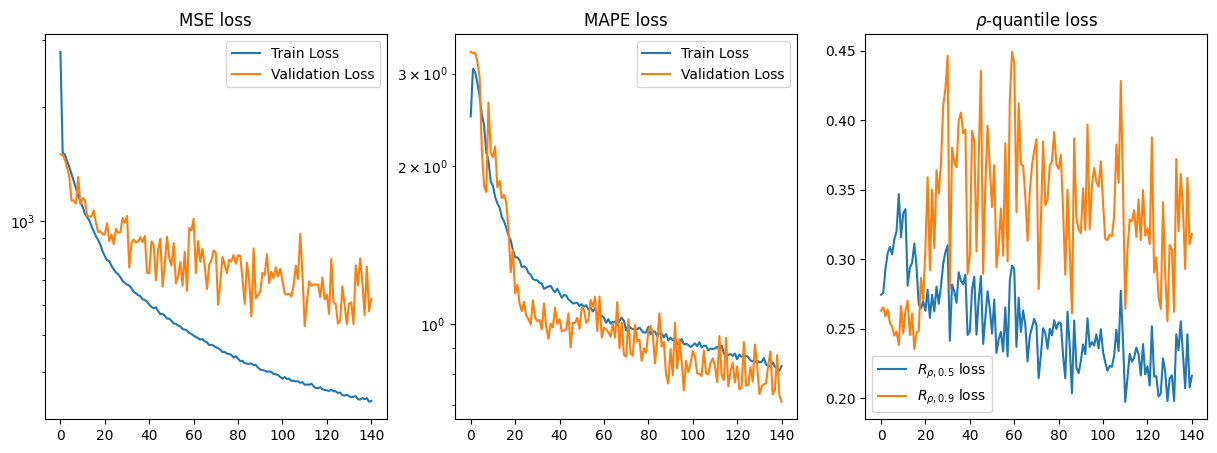

In [63]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [64]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(596.8886318359375,
 0.6751760172843934,
 [0.20799994468688965, 0.3058742582798004])

In [65]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [66]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(516.024115234375, 0.781137749671936, tensor([0.1935, 0.2607]))

### Predict

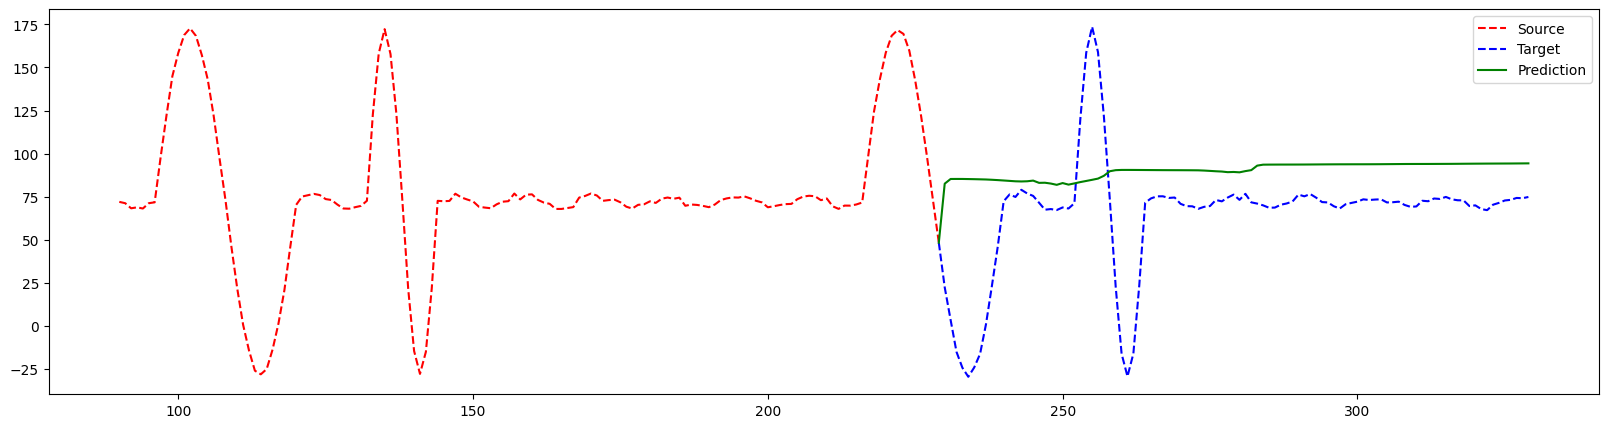

In [67]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()